In [94]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [57]:
def get_new_papers(labelled_data, fetched_pages) : 
    left_join = pd.merge(
        fetched_pages,
        labelled_data,
        on="url",
        how="left",
        suffixes=("", "_labelled"), 
        indicator=True,  # Pas de suffixe pour fetched_pages, "_labelled" pour labelled_data
    )

    # Récupérer uniquement les colonnes nécessaires (en évitant *_labelled si elles ne sont pas utiles)
    columns_to_keep = [col for col in left_join.columns if not col.endswith("_labelled")]
    left_join = left_join[columns_to_keep]

    # Récupérer uniquement les pages qui sont uniquement dans fetched_pages
    only_in_fetched = left_join[left_join["_merge"] == "left_only"].drop(columns=["_merge"])
    return(only_in_fetched)

In [87]:
def comparision_with_original_dataset(original_dataset, fetched_pages) : 
    labelled_data_relevants = original_dataset[original_dataset['relevance']==1]

    merged_data = pd.merge(original_dataset, fetched_pages, on="url", how="inner")
    merged_data['relevance'] = merged_data['relevance'].fillna(0)
    relevants = merged_data[merged_data['relevance']==1]

    only_in_fetched = get_new_papers(original_dataset, fetched_pages)

    recall = len(relevants) / len(labelled_data_relevants) if len(labelled_data_relevants) > 0 else 0
    precision = len(relevants) / len(merged_data) if len(merged_data) > 0 else 0

    print(f'nb papers fetched : {len(fetched_pages)}')
    print(f'nb papers already labelled : {len(merged_data)} ; nb papers not labelled : {len(only_in_fetched)}')
    print(f'nb relevant papers in labelled dataset : {len(labelled_data_relevants)}')
    print(f'nb relevant papers of labelled dataset fetched : {len(relevants)}')
    print(f'Recall for labelled dataset : {recall:.4f}')
    print(f'Precision for labelled dataset : {precision:.4f}')

In [92]:
def recall_precision(fetched_pages, labelled_dataset) : 
    labelled_data_relevants = labelled_dataset[labelled_dataset['relevance']==1]

    merged_data = pd.merge(labelled_dataset, fetched_pages, on="url", how="inner")
    merged_data['relevance'] = merged_data['relevance'].fillna(0)
    relevants = merged_data[merged_data['relevance']==1]

    recall = len(relevants) / len(labelled_data_relevants) if len(labelled_data_relevants) > 0 else 0
    precision = len(relevants) / len(merged_data) if len(merged_data) > 0 else 0

    return(recall, precision)

In [119]:
def query_count(session_infos_path, fetched_pages_path):
    session_infos = pd.read_csv(session_infos_path)
    fetched_pages = pd.read_csv(fetched_pages_path)
    print(fetched_pages.columns)

    queries_count = []

    queries = list(session_infos['all_queries'])[0].split(';')
    for query in queries:
        pages_for_query = fetched_pages[fetched_pages['get_with_query'] == query]
        num_pages_for_query = len(pages_for_query)
        queries_count.append(num_pages_for_query)

    index = [i for i in range(len(queries))]
    plt.figure(figsize=(10, 6))
    plt.bar(index, queries_count, edgecolor='black')
    plt.xlabel('Query Number')
    plt.ylabel('Number of Pages Found')
    plt.title('Number of Pages Found per Query')
    plt.show()

In [88]:
original_dataset = pd.read_csv("/Users/apollineguerineau/Documents/ENSAI/3A/Greece/internship/eval/RAG_code_generation/dataset_rag.csv", sep=';')
labelled_new_papers_path = "/Users/apollineguerineau/Documents/ENSAI/3A/Greece/internship/eval/RAG_code_generation/crawlers/all_new_pages_to_label.csv"
path_to_crawlers = "/Users/apollineguerineau/Documents/ENSAI/3A/Greece/internship/eval/RAG_code_generation/crawlers/"
crawlers = [f for f in os.listdir(path_to_crawlers) if os.path.isdir(os.path.join(path_to_crawlers, f))]
print(len(crawlers))

7


In [89]:
for crawler in crawlers : 
    print(crawler)
    path_fetched_pages = os.path.join(path_to_crawlers, crawler+"/fetched_pages.csv")
    fetched_pages = pd.read_csv(path_fetched_pages)
    comparision_with_original_dataset(original_dataset=original_dataset, fetched_pages=fetched_pages)
    print('--------------------------------------------------------')



none_sim_cos_thr_0.802_pages_None
nb papers fetched : 22
nb papers already labelled : 22 ; nb papers not labelled : 0
nb relevant papers in labelled dataset : 16
nb relevant papers of labelled dataset fetched : 16
Recall for labelled dataset : 1.0000
Precision for labelled dataset : 0.7273
--------------------------------------------------------
none_none_thr_none_pages_None
nb papers fetched : 23
nb papers already labelled : 23 ; nb papers not labelled : 0
nb relevant papers in labelled dataset : 16
nb relevant papers of labelled dataset fetched : 16
Recall for labelled dataset : 1.0000
Precision for labelled dataset : 0.6957
--------------------------------------------------------
best_paper_based_hyde_sim_cos_thr_0.882_pages_50
nb papers fetched : 587
nb papers already labelled : 22 ; nb papers not labelled : 565
nb relevant papers in labelled dataset : 16
nb relevant papers of labelled dataset fetched : 16
Recall for labelled dataset : 1.0000
Precision for labelled dataset : 0.7273

In [86]:
all_new_papers = []

for crawler in crawlers:
    path_fetched_pages = os.path.join(path_to_crawlers, crawler)
    fetched_pages = pd.read_csv(path_fetched_pages + "/fetched_pages.csv")
    only_in_fetched = get_new_papers(labelled_data=original_dataset, fetched_pages=fetched_pages)
    all_new_papers.append(only_in_fetched)

combined_new_papers = pd.concat(all_new_papers, ignore_index=True)

if os.path.exists(labelled_new_papers_path):
    labelled_new_papers = pd.read_csv(labelled_new_papers_path)  
    combined_new_papers = pd.concat([combined_new_papers,labelled_new_papers], ignore_index=True)

combined_new_papers["has_relevance"] = combined_new_papers["relevance"].notna()
combined_new_papers = combined_new_papers.sort_values(by="has_relevance", ascending=False)
unique_new_papers = combined_new_papers.drop_duplicates(subset=["url"])
columns_to_keep = ["url", "title", "description", "relevance"]
filtered_new_papers = unique_new_papers.loc[:, columns_to_keep]
filtered_new_papers.to_csv(os.path.join(path_to_crawlers, "all_new_pages_to_label.csv"), index=False)

print(f"Total new unique papers to label: {len(filtered_new_papers)}")


Total new unique papers to label: 1292


/var/folders/_q/jwd73s_9411cb6x2cl1l9q700000gn/T/ipykernel_20865/294494363.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_new_papers = pd.concat(all_new_papers, ignore_index=True)


In [90]:
if os.path.exists(labelled_new_papers_path):
    labelled_new_papers = pd.read_csv(labelled_new_papers_path)
    labelled_new_papers_with_label = labelled_new_papers.dropna(subset=['relevance'])
    
labelled_dataset_complete = pd.concat([labelled_new_papers_with_label,original_dataset], ignore_index=True)
print(len(original_dataset))
print(len(labelled_dataset_complete))


23
24


In [93]:
for crawler in crawlers:
    path_fetched_pages = os.path.join(path_to_crawlers, crawler)
    fetched_pages = pd.read_csv(path_fetched_pages + "/fetched_pages.csv")
    print(recall_precision(fetched_pages, labelled_dataset=labelled_dataset_complete))

(0.9411764705882353, 0.7272727272727273)
(0.9411764705882353, 0.6956521739130435)
(1.0, 0.7391304347826086)
(0.7058823529411765, 0.7058823529411765)
(0.9411764705882353, 0.7272727272727273)
(1.0, 0.7391304347826086)
(1.0, 0.7391304347826086)


Index(['url', 'title', 'description', 'score', 'get_with_query', 'time_fetch',
       'is_seed'],
      dtype='object')


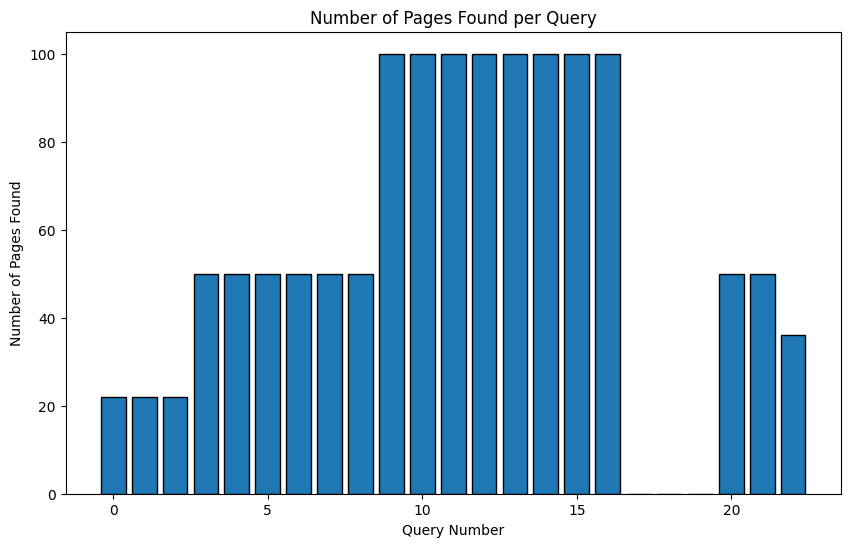

In [124]:
fetched_pages = os.path.join(path_to_crawlers, crawlers[6]) + "/fetched_pages.csv"
session_infos = os.path.join(path_to_crawlers, crawlers[6]) + "/session_infos.csv"

query_count(session_infos_path=session_infos, fetched_pages_path=fetched_pages)